In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [202]:

parent_folder = "box/"
output = "cropped_box_Pro/" # cropping to the middle rectangle


os.makedirs(output, exist_ok=True)

for ech_name in sorted(os.listdir(parent_folder), key=len):
    ech_dir = parent_folder + ech_name +'/'
    
    for image_name in os.listdir(ech_dir):
        img_dir = ech_dir + image_name
        img = cv2.imread(img_dir)

        if image_name.startswith('pro'):
            crop_factor = 5/100 # 5% of borders
        
        else: # 'simple'
            continue # skipping simple ones !!!!!
            crop_factor = 25e-2
        # cropping
        h, w, _ = img.shape
        h_min, h_max = int(crop_factor*h), h -int(crop_factor*h)
        w_min, w_max = int(crop_factor*w), w -int(crop_factor*w)
        
        cropped_img = img[h_min:h_max, w_min:w_max,:]

        # creating sub_folder
        os.makedirs(output+ech_name+'/', exist_ok=True)
        cv2.imwrite(output+ech_name+'/'+image_name, cropped_img)
    # break
    

### Segmenting based on histogramm:

In [28]:


def compute_histogram(image, channel_idx):
    # Compute the histogram for a specific channel (0 - Blue, 1 - Green, 2 - Red)
    hist = cv2.calcHist([image], [channel_idx], None, [256], [0, 256])
    return hist

def apply_blur(image, kernel_size=(5, 5)):
    # Apply Gaussian blur to the image
    return cv2.GaussianBlur(image, kernel_size, 0)

def get_grid_histograms(image, shrink_by=16, threshold=.8):
    # Get the dimensions of the image
    height, width, _ = image.shape
    grid_size=(height // shrink_by, width // shrink_by)
    
    histograms = []

    # Iterate through each cell of the grid
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            # Define the rectangle for the current grid cell
            y_start = i * shrink_by
            y_end = (i + 1) * shrink_by
            x_start = j * shrink_by
            x_end = (j + 1) * shrink_by

            # Crop the grid cell
            grid_cell = image[y_start:y_end, x_start:x_end]
            
            # Initialize the result for the grid cell
            cell_histogram = []

            # Compute the histograms for each color channel
            for channel_idx in range(3):
                hist = compute_histogram(grid_cell, channel_idx)
                # Find the index of the max value in the histogram
                max_idx = np.argmax(hist)
                cell_histogram.append(max_idx)

            histograms.append(cell_histogram)

    return np.array(histograms).reshape(grid_size[0], grid_size[1], 3)

def filter_histograms(histograms, goal_rect=(1/2, 1/2), threshold=5):
    
    height, width, _ = histograms.shape
    object_idx = (int(height * goal_rect[0]), int(width * goal_rect[1]))
    middle_hist = histograms[object_idx[0], object_idx[1]]
    
    diff = np.zeros([histograms.shape[0], histograms.shape[1]])

    for i in range(histograms.shape[0]):
        for j in range(histograms.shape[1]):
            diff[i,j] = np.sum(np.abs(histograms[i, j] - middle_hist))
            # if np.any(diff > threshold):
            #     filtered_histograms.append(histograms[i, j])
    
    diff -= diff.min()
    diff = diff/diff.max()

    out = 1-diff>0.8
    out = (out*255).astype(np.uint8)
    
    return out

def erode_dilate(image, k=5):
    kernel = np.ones((k,k), np.uint8)
    eroded_image = cv2.erode(image, kernel, iterations=1)
    dilated_image = cv2.dilate(eroded_image, kernel, iterations=3)
    eroded_image = cv2.erode(dilated_image, kernel, iterations=1)
    return eroded_image

# def extract_contour_binary(bnr_image):
#     contours, hierarchy = cv2.findContours(bnr_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     return max(contours, key=cv2.contourArea)

def extract_contour_binary(bnr_image):
    # Get the image dimensions
    height, width = bnr_image.shape
    
    # Find the middle pixel coordinates
    middle_pixel = (width // 2, height // 2)
    
    # Find contours
    contours, hierarchy = cv2.findContours(bnr_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours to only include those that contain the middle pixel
    contours_with_middle_pixel = [
        contour for contour in contours if cv2.pointPolygonTest(contour, middle_pixel, False) >= 0
    ]
    
    # If no contours contain the middle pixel, return None (or handle appropriately)
    if not contours_with_middle_pixel:
        return None
    
    # Return the largest contour that contains the middle pixel
    return max(contours_with_middle_pixel, key=cv2.contourArea)


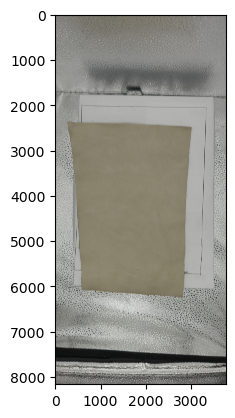

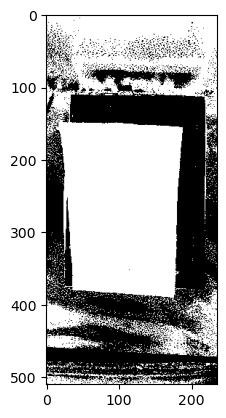

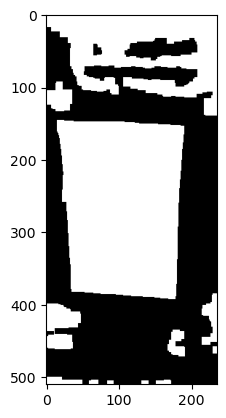

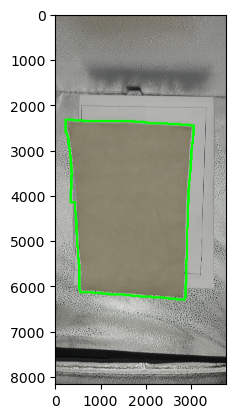

In [27]:
parent_folder = "box/"

# Load the image (replace 'image_path' with your image file path)
image = cv2.imread(parent_folder+'ech25/simple_50.jpg')
# Convert from BGR (OpenCV format) to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.show()
# print(parent_folder+'ech12/simple_50.jpg')
image.shape

# Apply blur to the image
blurred_image = apply_blur(image_rgb)

# Get the histograms of each grid cell
histograms = get_grid_histograms(blurred_image)


diff = filter_histograms(histograms)
plt.imshow(diff, cmap='grey')
plt.show()

process_img = erode_dilate(diff)
plt.imshow(process_img, cmap='grey')
plt.show()

bnr_image = cv2.resize(process_img, (image.shape[1], image.shape[0]))
contour = extract_contour_binary(bnr_image)
color_image = image_rgb.copy()
cv2.drawContours(color_image, [contour], -1, (0, 255, 0), 50)
plt.imshow(color_image)
plt.show()



## Testing on all simple 50 images :

In [29]:
def test_contour_extraction(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    blurred_image = apply_blur(image_rgb)
    histograms = get_grid_histograms(blurred_image)
    diff = filter_histograms(histograms)
    processed_img = erode_dilate(diff)
    bnr_image = cv2.resize(processed_img, (image.shape[1], image.shape[0]))
    contour = extract_contour_binary(bnr_image)
    color_image = image_rgb.copy()
    
    if contour is not None:
        cv2.drawContours(color_image, [contour], -1, (0, 255, 0), 50)
    
    return color_image


    

In [31]:
parent_folder = "box/"
output = "cropped_box_Pro/" # cropping to the middle rectangle

all_segments = []
for ech_name in sorted(os.listdir(parent_folder), key=len):
    ech_dir = parent_folder + ech_name +'/simple_50.jpg'
    output = test_contour_extraction(ech_dir)
    all_segments.append(output)
    # add output to an array

all_segments = np.array(all_segments)

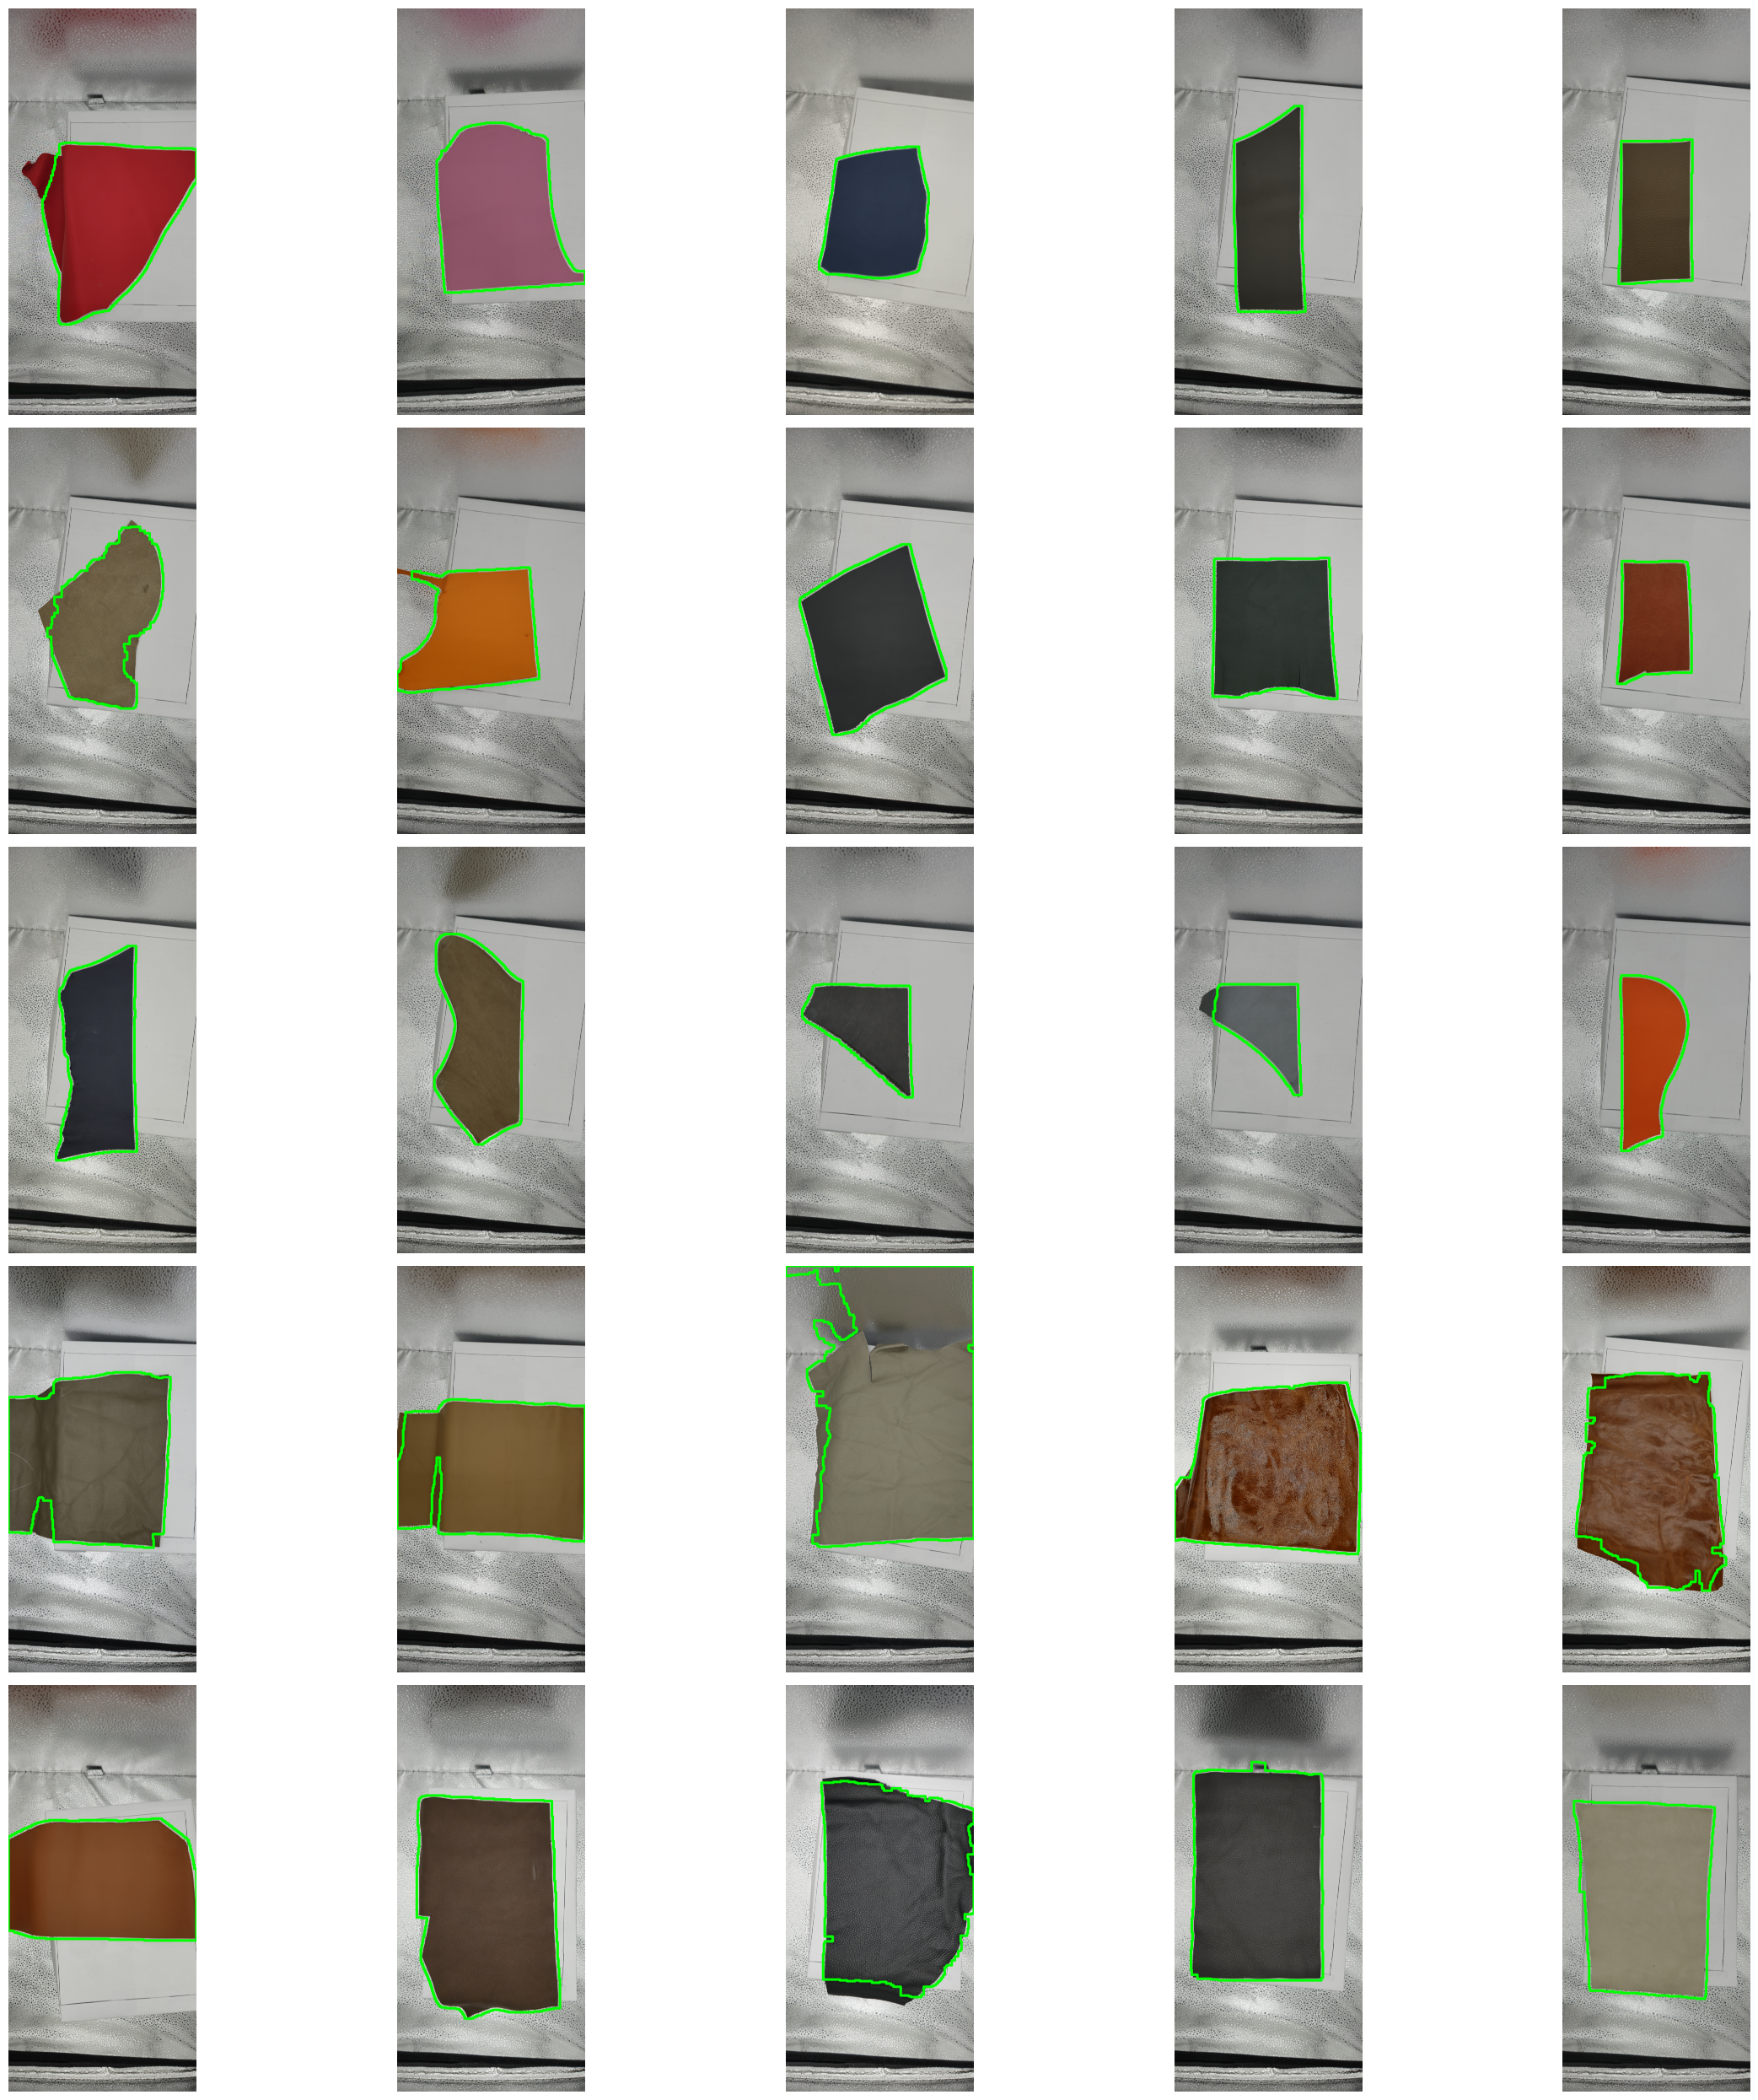

In [34]:
fig, axes = plt.subplots(5, 5, figsize=(25, 25))

for i in range(all_segments.shape[0]):
    ax = axes[i // 5, i % 5]
        
    # Plot the image in the grid, hide axes for each subplot
    ax.imshow(all_segments[i])
    ax.axis('off')

plt.tight_layout()
plt.show()